In [2]:
import os
from glob import glob

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
    
from IPython.display import Markdown, display
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

import sys
sys.path.append('..')
from roco2 import color, marker, plot, Kernel

In [3]:
import seaborn as sns
sns.set_context("paper")
mpl.rcParams['figure.figsize'] = [8, 4]

In [4]:

#import pylab
#pylab.rcParams['figure.figsize'] = (20,10)
#pylab.rcParams['font.size'] = 20
#pylab.rcParams['legend.fontsize'] = 20
def printmd(string):
    display(Markdown(string))

In [5]:
def old_kernel(n):
    return {
        0: Kernel.idle,
        1: Kernel.sine,
        2: Kernel.busywait,
        3: Kernel.memory,
        4: Kernel.compute,
        5: Kernel.mulpd,
        7: Kernel.matmul,
        8: Kernel.sqrt,
        9: Kernel.idle,
        10: Kernel.addpd,
        42: Kernel.firestarter
    }[n]


In [7]:
pp_dir = '/home/tilsche/diss/results/roco2/charon'
filenames = sorted(glob(pp_dir + os.path.sep + '*.tsv'))
filename_widget = widgets.Dropdown(options=filenames)
power_patterns = {
    'diana/watts': 'LMG reference measurement [W]',
    'diana/s.*': 'HAEC reference measurement [W]',
    'artemis/s.*': 'HAEC reference measurement [W]',
    'artemis/watts': 'LMG reference measurement [W]',
    'bogda/watts': 'LMG reference measurement [W]',
    'localhost/watts': 'LMG reference measurement [W]',
    'package.*': 'RAPL package + DRAM [W]',
    'x86_energy/.*/P': 'RAPL package + DRAM [W]',
    'x86_energy/P': 'RAPL package [W]',
    '.* RAPL PCKG': 'RAPL package [W]',
    '.* RAPL DRAM': 'RAPL dram [W]',
    '.* RAPL SINGLE_CORE': 'RAPL sum core [W]',
    '.* RAPL *': 'RAPL sum total [W]',
    'elab.ariel.power': 'LMG 450 AC reference measurement [W]',
    'elab.charon.power': 'LMG 450 AC reference measurement [W]',
    'elab.ariel.s.*': 'LMG 670 DC reference measurement [W]',
    'elab.ariel.s..package.power*': 'LMG 670 DC package reference measurement [W]',
    'elab.ariel.s..dram.power*': 'LMG 670 DC DRAM reference measurement [W]',
}
pattern_x_widget = widgets.Dropdown(options=tuple(power_patterns.keys()))
pattern_y_widget = widgets.Dropdown(options=tuple(power_patterns.keys()))

def update_filename(*args):
    tmp = pd.read_csv(filename_widget.value, sep='\t', quotechar="'")
    opt = tuple(filter(lambda pattern: len(tmp.filter(regex=pattern).columns) > 0, power_patterns.keys()))
    pattern_x_widget.options = opt
    pattern_y_widget.options = opt
    
filename_widget.observe(update_filename, 'value')
update_filename()

label_x = None
label_y = None
def read_phase_profile(filename, pattern_x, pattern_y):
    global experiments, label_x, label_y, experiment_basename
    experiments = pd.read_csv(filename, sep='\t', quotechar="'")
    experiment_basename = os.path.splitext(os.path.basename(filename))[0]
    printmd("### Number of experiments in {}: {}".format(experiment_basename, len(experiments)))
        
    label_x = power_patterns[pattern_x]
    label_y = power_patterns[pattern_y]
    power_x_columns = experiments.filter(regex=pattern_x)
    power_y_columns = experiments.filter(regex=pattern_y)
    printmd("### Using X-{} power metrics: {} [{}]" \
            .format(label_x, pattern_x, ', '.join(power_x_columns.columns.values)))
    printmd("### Using Y-{} power metrics: {} [{}]" \
            .format(label_y, pattern_y, ', '.join(power_y_columns.columns.values)))

    if experiments.experiment.max() == 42:
        experiments['kernel'] = experiments.experiment.apply(old_kernel)
    else:
        experiments['kernel'] = experiments.experiment.apply(Kernel)
        
    experiments['power_x'] = power_x_columns.sum(1)
    experiments['power_y'] = power_y_columns.sum(1)
    #experiments['power_x'] = (experiments['x86_energy/PACKAGE0/P'] + experiments['x86_energy/PACKAGE1/P'] + 0.25 * (experiments['x86_energy/DRAM0/P'] + experiments['x86_energy/DRAM1/P']) ) /1000
    experiments['frequency_mhz'] = (experiments['frequency'] / 1e6).astype(int)
    
    printmd('### Experiment duration: {:.1f} s'.format((experiments.end - experiments.begin).mean() / 1e12))
    
    printmd('### Kernels:')
    printmd('\n'.join([' * {}'.format(x) for x in experiments.kernel.unique()]))

    printmd('### Frequencies:')
    printmd('\n'.join([' * {}'.format(x) for x in experiments.frequency_mhz.unique()]))
    
    printmd('### Thread counts:')
    printmd('\n'.join([' * {}'.format(x) for x in experiments.thread_count.unique()]))
        

i = interact(read_phase_profile, filename=filename_widget,
             pattern_x=pattern_x_widget, pattern_y=pattern_y_widget)

interactive(children=(Dropdown(description='filename', options=('/home/tilsche/diss/results/roco2/charon/outpu…

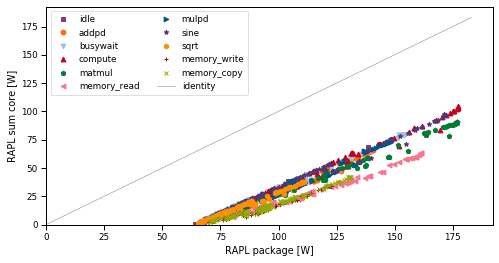

In [17]:
for kernel, k_group in experiments.groupby('kernel'):
    plt.plot(k_group.power_x, k_group.power_y, color=kernel.color, marker=kernel.marker, ls='', label=kernel.name)
    
x_min, x_max = plt.gca().get_xlim()
x_plot = np.linspace(x_min, x_max, 100)

#plt.plot(x_plot, model.predict(x_plot.reshape(-1,1)), ls=':', color='black', label='{} fit'.format(model_name))
plt.xlabel(label_x)
plt.ylabel(label_y)
plot.ideal(x_max, ls='-', color='gray', label='identity')

plt.gca().set_xlim(xmin=0)
plt.gca().set_ylim(ymin=0)
plt.legend(loc='best', numpoints=1, ncol=2)

plot.make_pdf(experiment_basename)

plt.show()